# Old or not

## Business Understanding: 
Van volwassen beroemdheden is het vaak lastig te zeggen hoe oud ze zijn. Nu gaan we kijken of we een neuraal netwerk kunnen bouwen wat dit beter kan schatten dan wij. We nemens als grens de compleet arbitraire waarde van 42 jaar. Iedereen tussen de 21 en 42 noemen we 'not old' en iedereen boven deze grens definieren we als 'old' 

We gebruiken hiervoor de IMDB faces database met daarin meer dan 460.000 gezichten van een dikke 20.000 beroemdheden afkomstig van IMDB (zie https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ voor uitleg en details) en hierbij de IMDB informatie over o.a. leeftijd en geslacht. We downloaden hier de de cropped IMDB dataset( https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar). De metadata wordt in .mat (matlab) bestand meegeleverd. 

- We beperken ons tot volwassen beroemdheden. <u>Iedereen onder de 21 jaar mag je overslaan.</u>
- Er zitten nogal wat foto's met meerdere gezichten of geen gezicht op. <u>Deze mag je eruit filteren</u>
- We verwachten niet alleen de code maar (in het notebook) ook een <u>uitleg</u> van waarom je dingen hebt gedaan. 
- I.v.m. performance issues gebruiken we na opschoning alleen de <u>1e 50.000</u> records als data
- Gebruik <u>20% van je data als testset, gebruik 42 als random state</u>
- Eindig met de mogelijkheid om een jpg van bijv. jezelf in te lezen en d.m.v. het getrainde netwerk te bepalen of diegene wel of niet oud is.

Vul je antwoorden steeds op de juiste plaats in. Maak indien nodig extra cellen aan.

## Data Understanding: 

In [96]:
import pandas as pd
#importeer de juiste packages
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import tarfile
from scipy.io import loadmat
from datetime import date, datetime, timedelta
import os
from sklearn.model_selection import train_test_split
import re
from PIL import Image

In [100]:
# Definieer het pad naar de .tar dataset en de .mat metadata
tar_file_path = 'data_huiswerk/imdb_crop.tar'
metadata_path = 'data_huiswerk/imdb.mat'

# alleen doen als de map nog niet bestaat
# We openen en extraheren de tar file 
# if tarfile.is_tarfile(tar_file_path):
#     with tarfile.open(tar_file_path, 'r') as tar:
#         tar.extractall(path='data_huiswerk/extracted_imdb')
# else:
#     print("Het opgegeven bestand is geen geldig tar-bestand.")

# Laad de metadata uit de .mat file
metadata = loadmat(metadata_path)

# Bekijk de structuur van de metadata
print(metadata.keys())

dict_keys(['__header__', '__version__', '__globals__', 'imdb'])


In [108]:
imdb_data = metadata['imdb']
print(imdb_data.dtype)

[('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O'), ('celeb_names', 'O'), ('celeb_id', 'O')]


In [65]:
# Extract relevant fields from the imdb_data
file_paths = imdb_data[0][0][2]  # Bestandslocaties van de afbeeldingen
dob = imdb_data['dob'][0][0]  # Geboortedatums in 'datenum' formaat
photo_taken = imdb_data['photo_taken'][0][0]  # Het jaar waarin de foto genomen is
face_score = imdb_data['face_score'][0][0][0]  # Score voor gezichtsherkenning
second_face_score = imdb_data['second_face_score'][0][0][0]  # Score voor een tweede gezicht

print(file_paths)

[[array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43')
  array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44')
  array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43')
  ...
  array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44')
  array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44')
  array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')]]


## Data preparation: 

In [70]:
filepath = re.findall(r"'([^']+\.jpg)'", str(file_paths))
face_score = face_score[:6]
second_face_score = second_face_score[:6]
print(len(filepath))

6


In [109]:
def extract_dob(filepath):
    # Split de bestandsnaam op basis van underscores en punt
    parts = filepath.split('_')

    if len(parts) >= 4:
        dob = parts[-2]  # De geboortedatum staat op de derde laatste positie
        return dob
    else:
        return None

def extract_foto_taken(filepath):
    # Split de bestandsnaam op basis van underscores en punt
    parts = filepath.split('_')

    if len(parts) >= 4:
        foto_taken = parts[-1]  # Het jaar van de foto staat op de laatste positie
        foto_taken = foto_taken.split('.')[0]  # Verwijder de bestandsextensie
        return foto_taken
    else:
        return None

def calculate_age(dob_str, foto_taken_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    foto_taken = datetime.strptime(foto_taken_str, '%Y')

    # Calculate age when the photo was taken
    age_at_foto_taken = foto_taken.year - dob.year - ((foto_taken.month, foto_taken.day) < (dob.month, dob.day))

    return age_at_foto_taken

dob_list = [extract_dob(filepath) for filepath in filepath]
foto_taken_list = [extract_foto_taken(filepath) for filepath in filepath]

# Calculate age for each filepath
age = [calculate_age(dob, foto_taken) for dob, foto_taken in zip(dob_list, foto_taken_list)]

In [110]:
#voeg de ingelezen metadata en de berekende leeftijd samen tot een nieuwe dataset

data = {
    # Zorg ervoor dat de path correct wordt omgezet, direct de waarde gebruiken
    'file_path': filepath,
    'age': age,
    "dob": dob_list,
    "foto_taken": foto_taken_list,
    "face_score": face_score,
    "second_face_score": second_face_score
}
df = pd.DataFrame(data)
df

,file_path,age,dob,foto_taken,face_score,second_face_score
0,01/nm0000001_rm124825600_1899-5-10_1968.jpg,68,1899-5-10,1968,1.459693,1.118973
1,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,70,1899-5-10,1970,2.543198,1.852008
2,01/nm0000001_rm577153792_1899-5-10_1968.jpg,68,1899-5-10,1968,3.455579,2.985660
3,08/nm3994408_rm926592512_1989-12-29_2011.jpg,21,1989-12-29,2011,1.872117,NaN
4,08/nm3994408_rm943369728_1989-12-29_2011.jpg,21,1989-12-29,2011,1.158766,NaN
5,08/nm3994408_rm976924160_1989-12-29_2011.jpg,21,1989-12-29,2011,3.490563,1.345335


In [134]:
#schoon de dataset op op basis van de bij de business understanding gegeven criteria.
#df_filtered = df[(df['age'] >= 21) & (df['face_score'] > 1.0) & (df['second_face_score'].isna())]
df_filtered = df[(df['age'] >= 21) & (df['face_score'] > 1.0)]

# Splits de dataset in train- en testset
train_images, test_images = train_test_split(df_filtered['file_path'], test_size=0.2, random_state=42)
train_labels, test_labels = train_test_split(df_filtered['age'], test_size=0.2, random_state=42)

# Controleer de verdeling van de data
print(f"Train images set size: {len(train_images)}")
print(f"Test images set size: {len(test_images)}")
print(f"Train labels set size: {len(train_labels)}")
print(f"{train_labels}")

Train images set size: 4
Test images set size: 2
Train labels set size: 4
5    21
2    68
4    21
3    21
Name: age, dtype: int64


data_huiswerk/extracted_imdb/imdb_crop/08/nm3994408_rm976924160_1989-12-29_2011.jpg


(-0.5, 110.5, 110.5, -0.5)

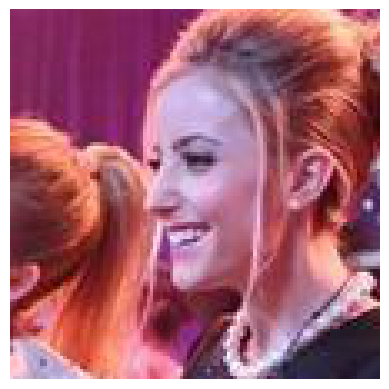

In [135]:
# Lees de afbeeldingen in
image_path = f"data_huiswerk/extracted_imdb/imdb_crop/{train_images.iloc[0]}"
print(image_path)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')


## Modeling: 

In [152]:
#normaliseer de data, train het model en valideer dit op de testdata
def open_img(path):
    img = Image.open(f"data_huiswerk/extracted_imdb/imdb_crop/{path}")
    img = img.resize((32, 32))  # Pas de afbeelding aan naar de invoergrootte van het netwerk
    return img

img_array = np.array(open_img(test_images.iloc[0])) / 255.0

print(len(img_array))
print(len(np.array(open_img(test_images.iloc[0]))/255.0))
print(test_labels.iloc[0])


32
32
68


In [ ]:
model = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(32*32*3, )),
    layers.Dense(16, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='ADAM',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(img_array, train_labels, epochs=25, validation_data=(np.array(open_img(test_images.iloc[0]))/255.0, test_labels))

## Evaluation: 

In [ ]:
# plot de accuracy en validated accuracy, toon de confusion matrix, 
# en toon de een aantal afbeeldingen inclusief of ze volgens het model wel of niet oud zijn,
# doe dit laatste ook voor een paar eigen afbeeldingen


Kunnen we met dit model betrouwbaar schatten of een beroemdheid oud is?
(type je antwoord en uitleg hieronder)